In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import imageio
from smpl_torch import SMPLModel
from enum import Enum
import cv2
import torch.nn as nn
from PIL import ImageFont, ImageDraw, Image

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)

from torch_openpose.body import Body
from torch_openpose import util

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm import tqdm

# add path for demo utils functions 
import sys
import os
import copy
sys.path.append(os.path.abspath(''))

In [2]:
def get_body_image_from_mesh(cur_mesh, body_estimation, renderer, R=None, T=None):
    if R is None:
        R, T = look_at_view_transform(2.0, 10, 0) 
        T[0, 1] = 0.3
    images = renderer(cur_mesh, R=R.cuda(), T=T.cuda())
        
    rendering_torch_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
    
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  images[0, ..., :3].detach().squeeze().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset, heatmap_avg, paf_avg

def where(cond, x_1, x_2):
    cond = cond.float()    
    return (cond * x_1) + ((1-cond) * x_2)


class Model(nn.Module):
    def __init__(self, target_image, renderer):
        super().__init__()
        self.device = torch.device("cuda:0")
        self.renderer = renderer
        self.smpl_model = SMPLModel(device=self.device)
        
        self.cur_mesh = None
        pose_size = 72
        beta_size = 10
        
        self.pose_params = nn.Parameter(
            torch.from_numpy(np.zeros(pose_size)).to(self.device)
        )
        
        self.betas = torch.from_numpy(
            np.zeros(beta_size)).type(torch.float64).to(self.device)
            
        self.trans = torch.from_numpy(np.zeros(3)).type(torch.float64).to(device)
        
        
        ## loss functions
        self.objective = torch.nn.MSELoss()
        #self.objective = torch.nn.L1Loss()
        
        self.verts_uvs = torch.from_numpy(np.load('uv_table.npy')).float().unsqueeze(0).cuda()
        self.maps = torch.from_numpy(
            cv2.cvtColor(cv2.imread("tex.png", cv2.IMREAD_COLOR),  cv2.COLOR_BGR2RGB) / 255
        ).unsqueeze(0).float().cuda()
        
        self.target_image = target_image
    
    def forward(self):
        # compute the verticies from the smpl model
        vertices = self.smpl_model(self.betas, self.pose_params, self.trans)
        
        verticies = vertices.unsqueeze(0).float()
        faces = torch.from_numpy(self.smpl_model.faces.astype(np.long)).unsqueeze(0).cuda()

        faces_uvs = faces.clone()
        
        textures = Textures(self.maps, faces_uvs, self.verts_uvs)
        self.cur_mesh = Meshes(verticies, faces, textures)
        R, T = look_at_view_transform(2.0, 10, 0) 
        T[0, 1] = 0.3
        
        images = self.renderer(self.cur_mesh, R=R.cuda(), T=T.cuda())
        ob_val_img_loss = self.objective(images, self.target_image)
        
        # Calculate the silhouette loss
        loss = ob_val_img_loss
        return loss, images

In [3]:
# Setup
ORIG_SHAPE = (512, 512, 3)
device = torch.device("cuda:0")
torch.cuda.set_device(device)
body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]
R, T = look_at_view_transform(2.0, 10, 0) 
T[0, 1] = 0.3
cameras = OpenGLPerspectiveCameras(device=device, R=R.cuda(), T=T.cuda())

raster_settings = RasterizationSettings(
    image_size=ORIG_SHAPE[0], 
    blur_radius=0.0, 
    faces_per_pixel=8, 
)

lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

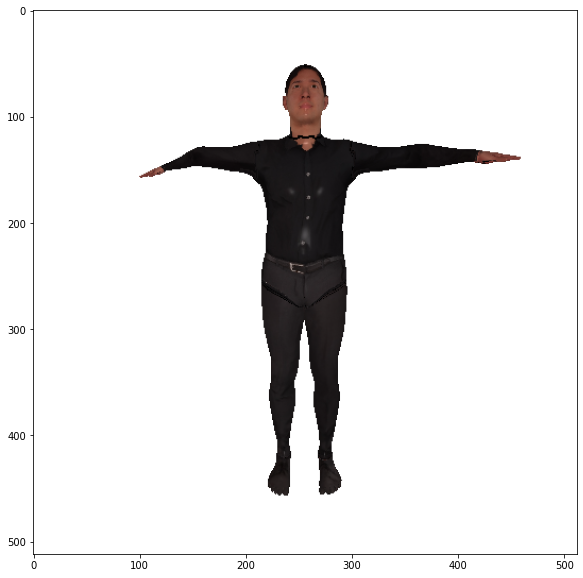

In [4]:
pose_size = 72
beta_size = 10

pose_np = np.zeros(pose_size)
pose_np[59] = 0.2 # elbow rotation

pose = torch.from_numpy(pose_np).type(torch.float64).to(device)
pose.requires_grad = True

betas_np = np.zeros(beta_size)
betas = torch.from_numpy(betas_np).type(torch.float64).to(device)
betas.requires_grad = True
trans = torch.from_numpy(np.zeros(3)).type(torch.float64).to(device)

model = SMPLModel(device=device)
vertices = model(betas, pose, trans)

verticies = vertices.unsqueeze(0).float()
faces = torch.from_numpy(model.faces.astype(np.long)).unsqueeze(0).cuda()

faces_uvs = faces.clone()
verts_uvs = torch.from_numpy(np.load('uv_table.npy')).float().unsqueeze(0).cuda()
maps = torch.from_numpy(
    cv2.cvtColor(cv2.imread("tex.png", cv2.IMREAD_COLOR),  cv2.COLOR_BGR2RGB) / 255
).unsqueeze(0).float().cuda()

textures = Textures(maps, faces_uvs, verts_uvs)

target_mesh = Meshes(verticies, faces, textures)

R, T = look_at_view_transform(2.0, 10, 0) 
T[0, 1] = 0.3
target_image = renderer(target_mesh, R=R.cuda(), T=T.cuda())


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(target_image[0, ..., :3].detach().cpu().numpy())

In [ ]:
model = Model(
    target_image=target_image,
    renderer=renderer,
).to(device)

font = ImageFont.truetype("arial.ttf", 20)
# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.0)
filename_output = "./gifs/smpl_pose_with_smpl_target_rendering.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)
losses = []
for i in tqdm(range(100)):
    optimizer.zero_grad()
    loss, cur_image = model()
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.item())
    #wandb.log({'loss': loss.item()}, step=i)
    
    rendering_torch_np =  cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
    
    canvas = np.clip(rendering_torch_np, -1, 1)
    canvas = img_as_ubyte(canvas)
    
    # addtext 
    pil_im = Image.fromarray(canvas)
    draw = ImageDraw.Draw(pil_im)
    draw.text((0, 0), f"it: {i}", font=font, fill ="blue")
    
    writer.append_data(np.array(pil_im))
    
writer.close()

![SegmentLocal](gifs/smpl_pose_with_smpl_target_rendering.gif "segment")

In [12]:
R, T = look_at_view_transform(2.0, 10, 0) 
T[0, 1] = 0.3
result_image = renderer(model.cur_mesh, R=R.cuda(), T=T.cuda())

Text(0.5, 1.0, 'Result Pose')

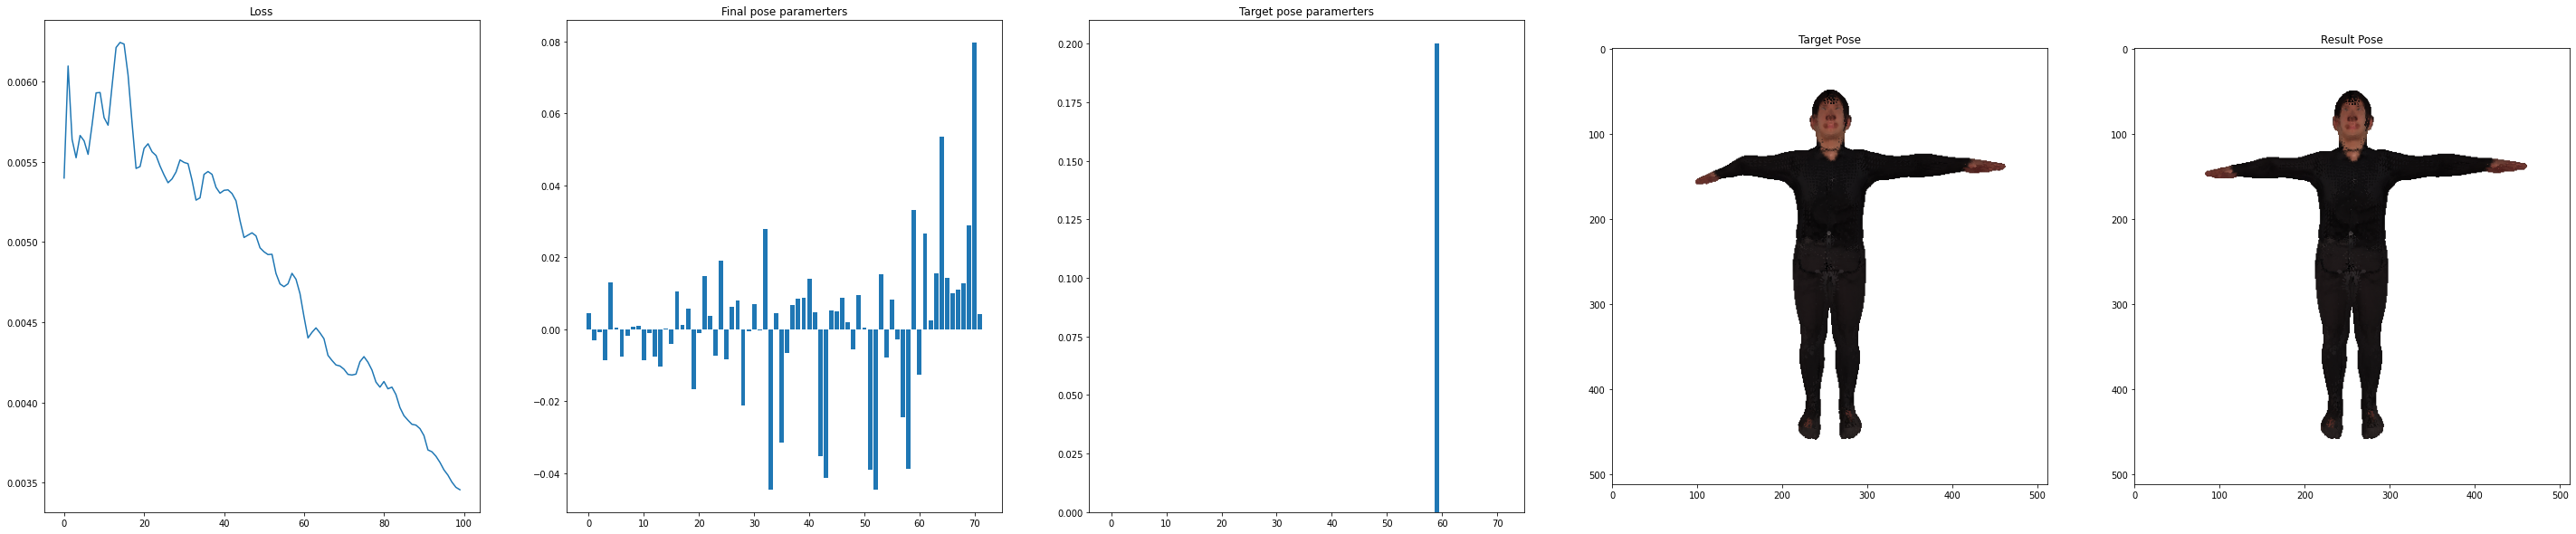

In [13]:
fig = plt.figure(figsize=(50, 10))
ax = fig.add_subplot(1, 5, 1)
ax.plot(losses)
ax.set_title(f"Loss")

ax = fig.add_subplot(1, 5, 2)
y =  model.pose_params.detach().cpu().numpy()
x = range(len(y))
ax.bar(x, y)
ax.set_title(f"Final pose paramerters")

ax = fig.add_subplot(1, 5, 3)
y =  pose_np
x = range(len(y))
ax.bar(x, y)
ax.set_title(f"Target pose paramerters")


ax = fig.add_subplot(1, 5, 4)
ax.imshow(target_image[0, ..., :3].detach().cpu().numpy())
ax.set_title(f"Target Pose")

ax = fig.add_subplot(1, 5, 5)
ax.imshow(result_image[0, ..., :3].detach().cpu().numpy())
ax.set_title(f"Result Pose")